Epoch 200 Loss 0.9438
Epoch 400 Loss 0.3520
Epoch 600 Loss 0.0928
Epoch 800 Loss 0.0718
Epoch 1000 Loss 0.0277


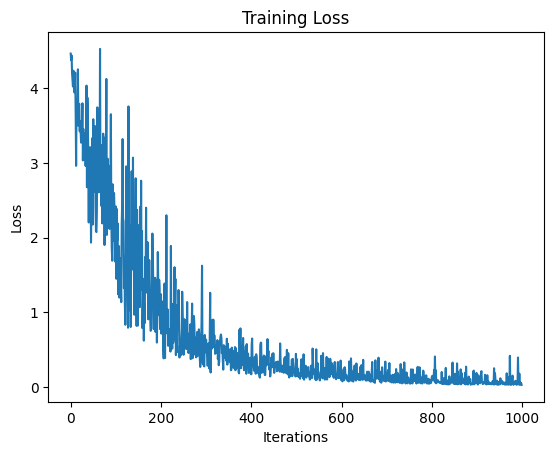

User: hi
Bot: hello ! how are you ?

User: what is your name
Bot: i am chatpy your friendly chatbot !

User: tell me a joke
Bot: why did the chicken cross the road ? to get to the other side !

User: how are you
Bot: i am timeless !

User: bye
Bot: goodbye ! have a great day !



In [3]:
# ============================================
# ChatPy: Custom Chatbot Implementation
# Module: Neural Systems & NLP (CSIP5103)
# ============================================

# Step 1: Import required libraries
import re
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
# nltk.download('punkt')
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Step 2: Dataset preparation
# Small custom dataset of conversational pairs
pairs = [
    ["hi", "hello! how are you?"],
    ["how are you", "i am good, thank you! how about you?"],
    ["what is your name", "i am chatpy, your friendly chatbot!"],
    ["tell me a joke", "why did the chicken cross the road? to get to the other side!"],
    ["bye", "goodbye! have a great day!"],
    ["hello", "hi there!"],
    ["how old are you", "i am timeless!"],
    ["what do you do", "i chat with humans and learn new things!"],
    ["thank you", "you're welcome!"],
    ["what is ai", "artificial intelligence is the simulation of human intelligence in machines."],
    ["what is your favorite color", "i like all colors equally!"],
    ["can you help me", "sure! i will try my best to help you."],
    ["who created you", "i was created by a Python programmer!"],
    ["good morning", "good morning! how are you today?"],
    ["good night", "good night! sleep well!"]
]

# Step 3: Preprocessing
def normalize_string(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def tokenize_sentence(sentence):
    return word_tokenize(normalize_string(sentence))

tokenized_pairs = [[tokenize_sentence(a), tokenize_sentence(b)] for a,b in pairs]

# Build vocabulary
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.word2count = {}
        self.index2word = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.n_words = 4  # Count default tokens

    def add_sentence(self, sentence):
        for word in sentence:
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

vocab = Vocabulary()
for pair in tokenized_pairs:
    vocab.add_sentence(pair[0])
    vocab.add_sentence(pair[1])

# Step 4: Convert sentences to tensor indexes
def sentence_to_indexes(vocab, sentence):
    return [vocab.word2index.get(word, vocab.word2index["<UNK>"]) for word in sentence] + [vocab.word2index["<EOS>"]]

def indexes_to_sentence(vocab, indexes):
    return ' '.join([vocab.index2word[idx] for idx in indexes if idx not in [vocab.word2index["<PAD>"], vocab.word2index["<EOS>"]]])

# Step 5: Define Seq2Seq Model
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1,1,-1)
        output = torch.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

# Step 6: Training Preparation
hidden_size = 256
encoder = EncoderRNN(vocab.n_words, hidden_size)
decoder = DecoderRNN(hidden_size, vocab.n_words)

encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Prepare training data
training_pairs = [(torch.tensor(sentence_to_indexes(vocab,pair[0]), dtype=torch.long),
                   torch.tensor(sentence_to_indexes(vocab,pair[1]), dtype=torch.long))
                  for pair in tokenized_pairs]

# Step 7: Training Function
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=20):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    loss = 0

    # Encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei].view(1), encoder_hidden)

    # Decoder
    decoder_input = torch.tensor([vocab.word2index["<SOS>"]])
    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = target_tensor[di].view(1)
        loss += criterion(decoder_output, target_tensor[di].view(1))

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

# Step 8: Train the model
n_epochs = 1000
print_every = 200
losses = []

for epoch in range(1, n_epochs+1):
    pair = random.choice(training_pairs)
    input_tensor, target_tensor = pair
    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    losses.append(loss)
    if epoch % print_every == 0:
        print(f"Epoch {epoch} Loss {loss:.4f}")

# Plot training loss
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Step 9: Evaluate Chatbot
def evaluate(encoder, decoder, sentence, max_length=20):
    with torch.no_grad():
        input_tensor = torch.tensor(sentence_to_indexes(vocab, tokenize_sentence(sentence)), dtype=torch.long)
        encoder_hidden = encoder.initHidden()
        for ei in range(input_tensor.size(0)):
            encoder_output, encoder_hidden = encoder(input_tensor[ei].view(1), encoder_hidden)
        decoder_input = torch.tensor([vocab.word2index["<SOS>"]])
        decoder_hidden = encoder_hidden
        decoded_words = []
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            if topi.item() == vocab.word2index["<EOS>"]:
                break
            else:
                decoded_words.append(vocab.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
        return ' '.join(decoded_words)

# Step 10: Test Conversations
test_sentences = ["hi", "what is your name", "tell me a joke", "how are you", "bye"]
for sentence in test_sentences:
    print(f"User: {sentence}")
    print(f"Bot: {evaluate(encoder, decoder, sentence)}\n")